# add flux breakdown

In [3]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [37]:
def RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,trans_i,t_max,i_app,L_tot):
    # constant definition
    F = 9.6E4;
    c_init = 1000; c_EC_init= 5000; c_tot_init = 7000;   # L_tot = 8E-3

    model = pybamm.BaseModel()
    c  = pybamm.Variable("Li+ Concentration", domain="negative electrode")
    co = pybamm.Variable("EC Concentration", domain="negative electrode")
    #i_app = pybamm.FullBroadcast(
    #            pybamm.Scalar(i_app_scale), "negative electrode", )
    
    N_diffusion          = - D_e*pybamm.grad(c) 
    N_cross_diffusion    = - D_cross*(c_init/c_tot_init)*pybamm.grad(co) 
    N_migration          =   t_0plus*i_app/F  # define the Li+ flux
    N    = N_cross_diffusion+N_diffusion +N_migration # define the EC flux

    N_EC_cross_diffusion   = - D_cross*(c_EC_init/c_tot_init)*pybamm.grad(c)
    N_EC_diffusion      =  - D_EC*pybamm.grad(co)
    N_EC_migration      =  - trans_i*i_app/F
    N_EC = N_EC_cross_diffusion+N_EC_diffusion  +N_EC_migration # define the EC flux


    dcdt  = -pybamm.div(N_cross_diffusion+N_diffusion)     # define the rhs equation for Li+
    dcodt = -pybamm.div( N_EC_cross_diffusion+N_EC_diffusion)  # define the rhs equation for EC
    model.rhs = {c: dcdt,co:dcodt}  # add the equation to rhs dictionary
    # initial conditions
    model.initial_conditions = {c: pybamm.Scalar(c_init),co: pybamm.Scalar(c_EC_init)}
    # boundary conditions

    # calculate for boundary conditions:
    a1 = D_e;                               b1 = D_cross * (c_init/c_tot_init);   

    c1_left = -(1-t_0plus)*i_app/F; 
    c1_right = -(1-t_0plus)*i_app/F;

    a2 = D_cross * (c_EC_init/c_tot_init);  b2 = D_EC;                            c2 = -trans_i*i_app/F;

    y_temp_left = (c2 - a2/a1*c1_left) / (b2 - a2/a1*b1);   x_temp_left = (c1_left - b1*y_temp_left) / a1
    y_temp_right = (c2 - a2/a1*c1_right) / (b2 - a2/a1*b1);   x_temp_right = (c1_right - b1*y_temp_right) / a1


    model.boundary_conditions = {
        c: {"left": (x_temp_left, "Neumann"),"right": (x_temp_right, "Neumann")},  
        co: {"left": (y_temp_left, "Neumann"),"right": (y_temp_right, "Neumann")} }
    model.variables = {
        "Li+ Concentration": c, 
        "Li+ flux": N,
        "EC Concentration": co, 
        "EC flux": N_EC    , 
        
        "EC flux by diffusion": N_EC_diffusion,

        "EC flux by Li+": N_EC_cross_diffusion,
        "Li+ flux by diffusion": N_diffusion,

        "Li+ flux by solvent": N_cross_diffusion,

        "Minus div Li+ flux": - pybamm.div(N),
        "Minus div EC flux": - pybamm.div(N_EC),
        "Minus div EC flux by diffusion": - pybamm.div( N_EC_diffusion),
        "Minus div EC flux by Li+": - pybamm.div(N_EC_cross_diffusion),
        "Minus div Li+ flux by diffusion": - pybamm.div(N_diffusion),
        "Minus div Li+ flux by solvent": - pybamm.div(N_cross_diffusion),
        
        }
    # define geometry
    x = pybamm.SpatialVariable(
        "x", domain=["negative electrode"], coord_sys="cartesian"
    )
    geometry = {"negative electrode": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(L_tot)}}}
    #model.length_scales = {"negative electrode": 1e1,}
    #model.timescale = pybamm.Scalar(L_tot ** 2 /  D_e) 
    # mesh and discretise
    submesh_types = {"negative electrode": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh)}
    var_pts = {x: 40}
    mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
    spatial_methods = {"negative electrode": pybamm.FiniteVolume()}
    disc = pybamm.Discretisation(mesh, spatial_methods)
    disc.process_model(model);

    # solve
    solver = pybamm.ScipySolver()
    t = np.linspace(0, t_max, 100)
    solution = solver.solve(model, t)

    # post-process, so that the solution can be called at any time t or space r
    # (using interpolation)
    c = solution["Li+ Concentration"];  co = solution["EC Concentration"];
    N = solution["Li+ flux"];      N_EC = solution["EC flux"];

    N_EC_diffusion=solution["EC flux by diffusion"] 
    N_EC_cross_diffusion=solution["EC flux by Li+"] 

    Minus_div_N_EC=solution["Minus div EC flux"] 
    Minus_div_N_EC_diffusion=solution["Minus div EC flux by diffusion"] 
    Minus_div_N_EC_cross_diffusion=solution["Minus div EC flux by Li+"] 
    
    N_diffusion=solution["Li+ flux by diffusion"] 

    N_cross_diffusion=solution["Li+ flux by solvent"] 

    Minus_div_N=solution["Minus div Li+ flux"] 
    Minus_div_N_diffusion=solution["Minus div Li+ flux by diffusion"] 
    Minus_div_N_cross_diffusion=solution["Minus div Li+ flux by solvent"] 

    LinesNmum = 10; 
    t_plot = np.linspace(0, t_max, LinesNmum)

    # plot concentration 
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    x= np.linspace(0, L_tot, 100)
    cmap_i = mpl.cm.get_cmap('cool', LinesNmum) 
    for i in range(0,LinesNmum):
        axs[0].plot(x, co(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1].plot(x, c(t=t_plot[i], x=x),color=cmap_i(i),)
    axs[0].set_xlabel("x [m]")
    axs[0].set_title("EC concentration [mol/m3]")
    axs[1].set_xlabel("x")
    #axs[1].set_ylabel("Li+ concentration [mol/m3]")
    axs[1].set_title("Li+ concentration [mol/m3]")
    plt.tight_layout()
    plt.show()

    # plot Li+ flux 
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    x= np.linspace(0, L_tot, 100)
    cmap_i = mpl.cm.get_cmap('cool', LinesNmum) 
    for i in range(0,LinesNmum):
        axs[0,0].plot(x, N(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[0,1].plot(x, N_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1,0].plot(x, np.full(x.shape,N_migration),color=cmap_i(i),)
        axs[1,1].plot(x, N_cross_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
    axs[0,0].set_xlabel("x [m]");axs[0,1].set_xlabel("x [m]");axs[1,0].set_xlabel("x [m]");axs[1,1].set_xlabel("x [m]");
    axs[0,0].set_title("Li+ flux");axs[0,1].set_title("Li+ flux by diffusion");
    axs[1,0].set_title("Li+ flux by migration");axs[1,1].set_title("Li+ flux by solvent");
    plt.tight_layout()
    plt.show()

    # plot EC flux 
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    x= np.linspace(0, L_tot, 100)
    cmap_i = mpl.cm.get_cmap('cool', LinesNmum) 
    for i in range(0,LinesNmum):
        axs[0,0].plot(x, N_EC(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[0,1].plot(x, N_EC_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1,0].plot(x, np.full(x.shape,N_EC_migration),color=cmap_i(i),)
        axs[1,1].plot(x, N_EC_cross_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
    axs[0,0].set_xlabel("x [m]");axs[0,1].set_xlabel("x [m]");axs[1,0].set_xlabel("x [m]");axs[1,1].set_xlabel("x [m]");
    axs[0,0].set_title("EC flux");axs[0,1].set_title("EC flux by diffusion");
    axs[1,0].set_title("EC flux by migration");axs[1,1].set_title("EC flux by Li+");
    plt.tight_layout()
    plt.show()

    # plot div Li+ flux 
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    x= np.linspace(0, L_tot, 100)
    cmap_i = mpl.cm.get_cmap('cool', LinesNmum) 
    for i in range(0,LinesNmum):
        axs[0,0].plot(x, c(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[0,1].plot(x, Minus_div_N(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1,0].plot(x, Minus_div_N_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1,1].plot(x, Minus_div_N_cross_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
    axs[0,0].set_xlabel("x [m]");axs[0,1].set_xlabel("x [m]");axs[1,0].set_xlabel("x [m]");axs[1,1].set_xlabel("x [m]");
    axs[0,0].set_title("Li+ concentration [mol/m3]");     axs[0,1].set_title("Minus div Li+ flux");
    axs[1,0].set_title("Minus div Li+ flux by diffusion");axs[1,1].set_title("Minus div Li+ flux by solvent");
    plt.tight_layout()
    plt.show()

    # plot div EC flux 
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    x= np.linspace(0, L_tot, 100)
    cmap_i = mpl.cm.get_cmap('cool', LinesNmum) 
    for i in range(0,LinesNmum):
        axs[0,0].plot(x, co(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[0,1].plot(x, Minus_div_N_EC(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1,0].plot(x, Minus_div_N_EC_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
        axs[1,1].plot(x, Minus_div_N_EC_cross_diffusion(t=t_plot[i], x=x),color=cmap_i(i),)
    axs[0,0].set_xlabel("x [m]");axs[0,1].set_xlabel("x [m]");axs[1,0].set_xlabel("x [m]");axs[1,1].set_xlabel("x [m]");
    axs[0,0].set_title("EC concentration [mol/m3]");     axs[0,1].set_title("Minus div EC flux");
    axs[1,0].set_title("Minus div EC flux by diffusion");axs[1,1].set_title("Minus div EC flux by Li+");
    plt.tight_layout()
    plt.show()

    return solution,model


t_max =2e5;
t_plot = np.linspace(0, t_max, 5)
t = np.linspace(0, t_max, 100)
print(t_plot[0])

In [35]:
# constant definition    D_e,D_EC,D_cross,t_0plus,trans_i
font = {'family' : 'DejaVu Sans','size'   : 13}
mpl.rc('font', **font)
D_e = 3e-10;  D_EC = 5e-10; D_cross = 1.5e-9;   t_0plus = 0.28; trans_i = -1.4;  t_max =72000; L_tot = 8e-3

2022-10-22 00:33:53.039 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:33:53.047 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:33:53.058 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:33:53.066 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:33:53.077 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:33:53.088 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:33:53.097 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electr

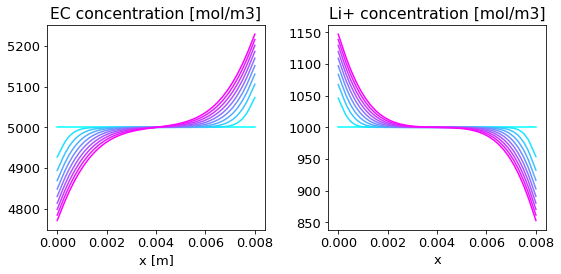

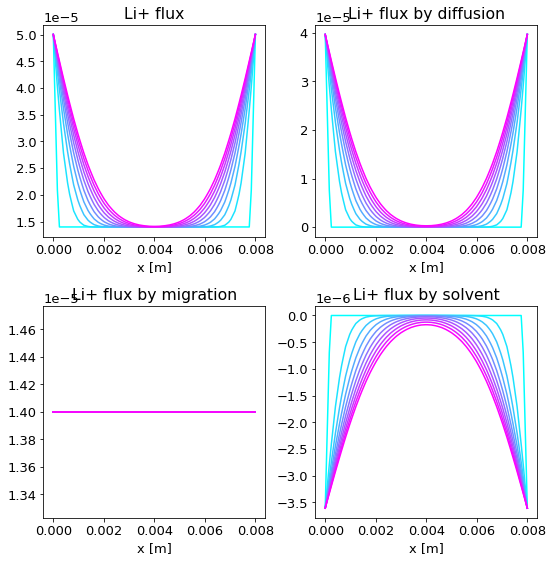

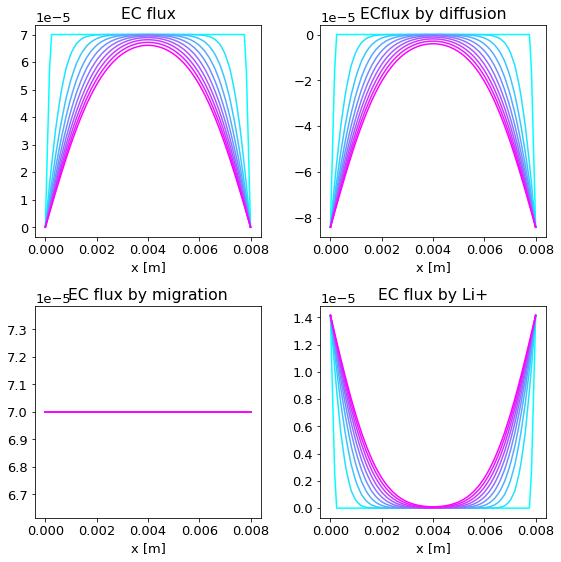

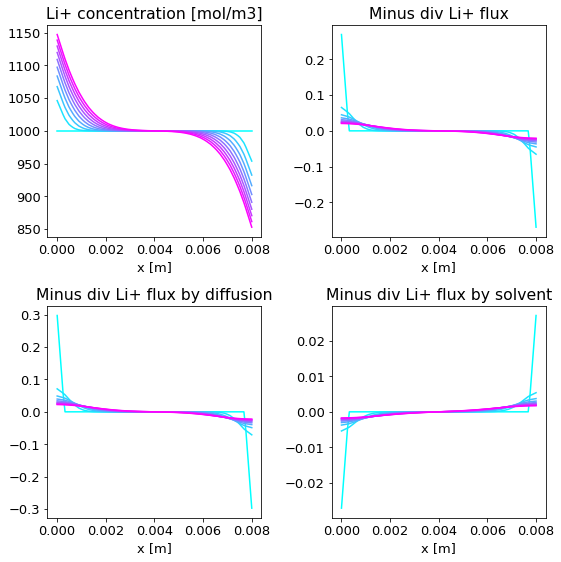

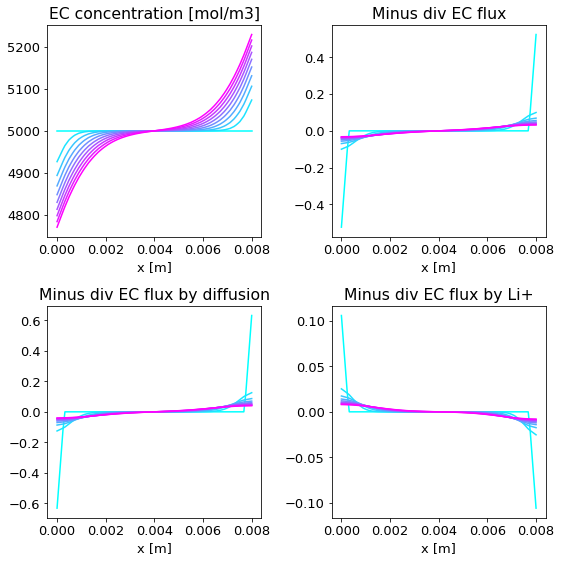

In [36]:
#RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,-1.4/100)
sol_0,model_0= RunHom_DoubleDiffusion(D_e,D_EC,D_cross/10,t_0plus,trans_i,3600,4.8 ,L_tot  )

2022-10-22 00:37:29.759 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:37:29.765 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:37:29.772 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:37:29.779 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:37:29.785 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:37:29.791 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:37:29.799 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electr

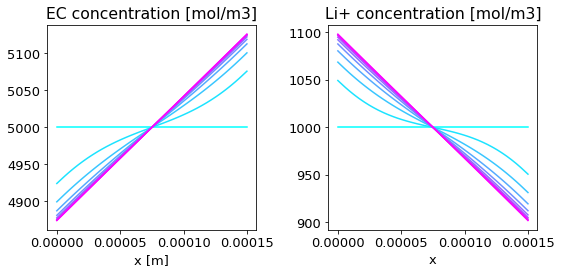

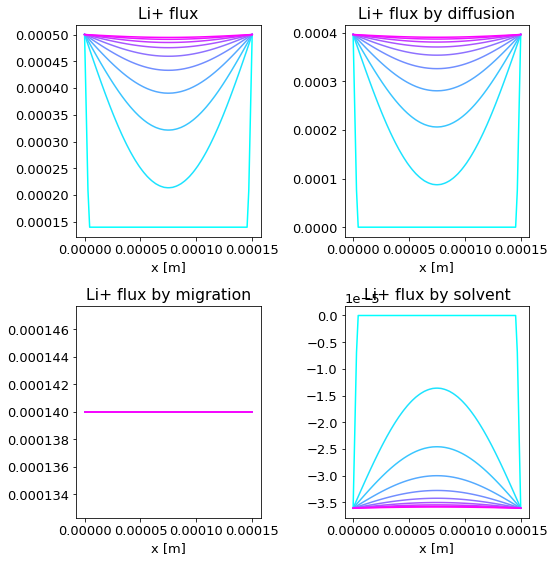

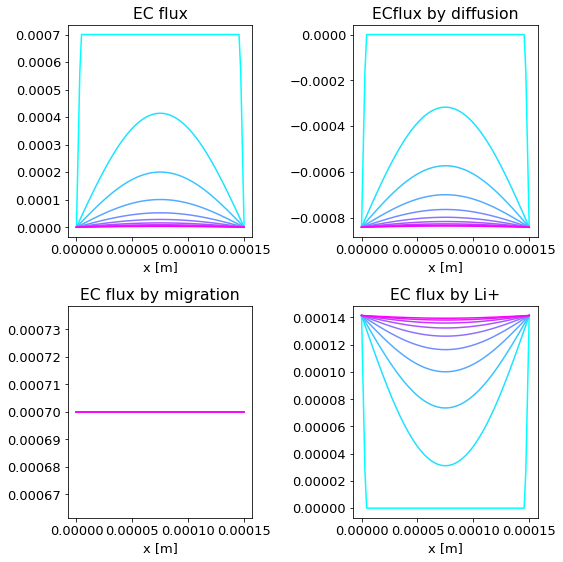

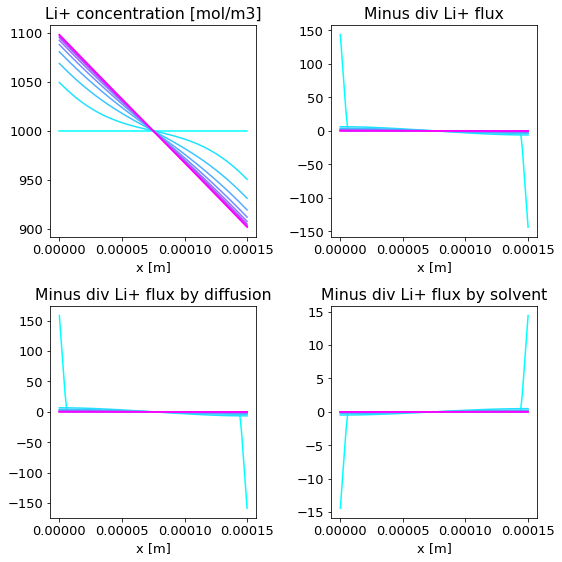

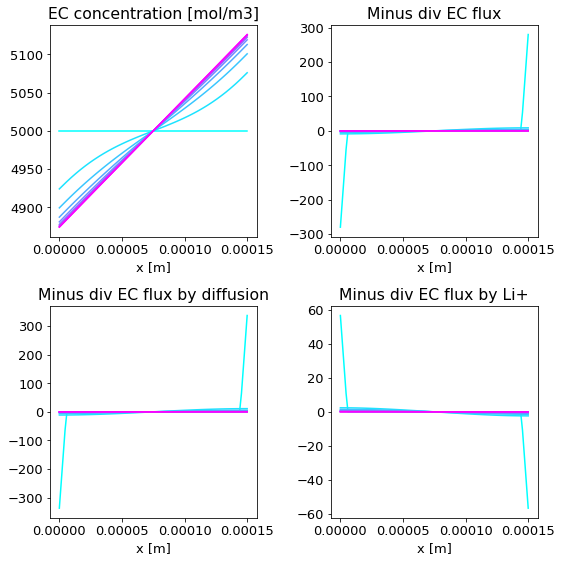

In [39]:
#RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,-1.4/100)
sol_1,model_1= RunHom_DoubleDiffusion(D_e,D_EC,D_cross/10,t_0plus,trans_i,36,48  ,1.5e-4 )

2022-10-22 00:41:38.827 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:41:38.837 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:41:38.844 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:41:38.852 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:41:38.861 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:41:38.872 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:41:38.880 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electr

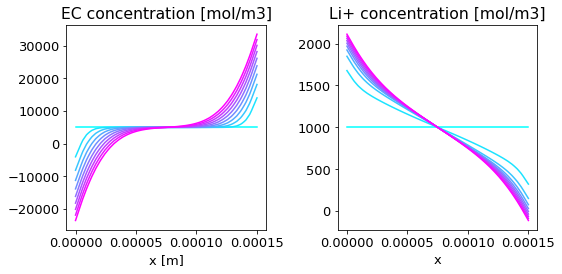

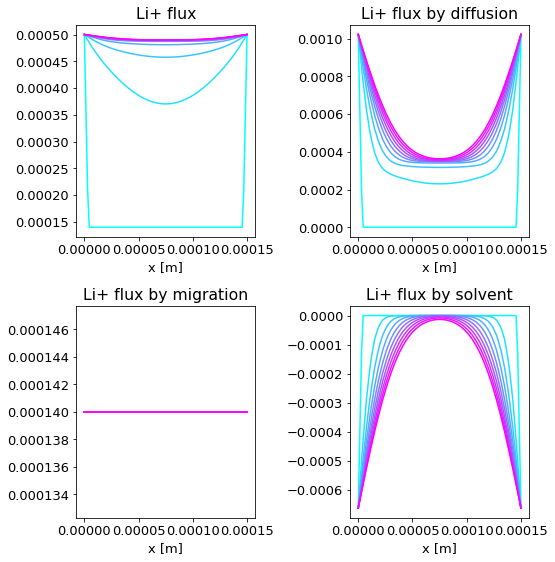

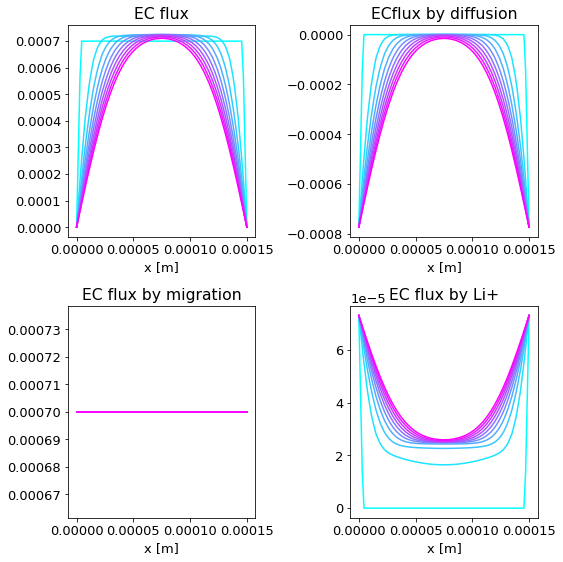

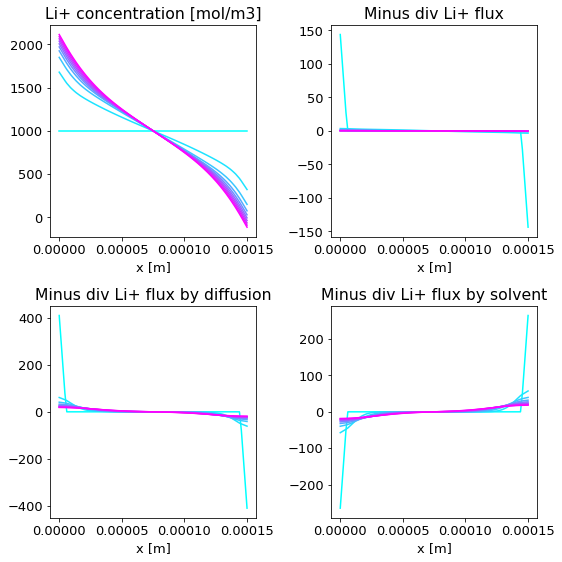

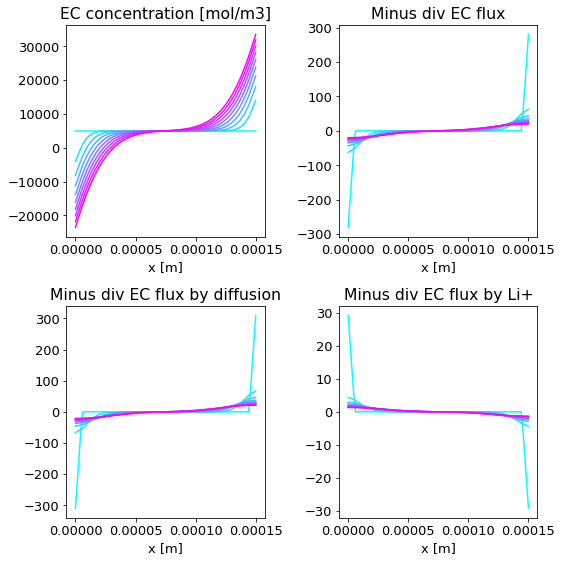

In [41]:
# mimic porous electrode:
D_e = 3e-10/8;  D_EC = 5e-12/8; D_cross = 3e-11/8;   t_0plus = 0.28; trans_i = -1.4;  t_max =720; i_app = 48; L_tot = 1.5e-4
sol_1,model_1= RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,trans_i,t_max ,i_app  ,L_tot )

2022-10-22 00:42:43.461 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:42:43.468 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:42:43.478 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:42:43.487 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:42:43.495 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:42:43.503 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electrode. Using default of 1 [m].
2022-10-22 00:42:43.512 - [WARNING] processed_variable.get_spatial_scale(521): No length scale set for negative electr

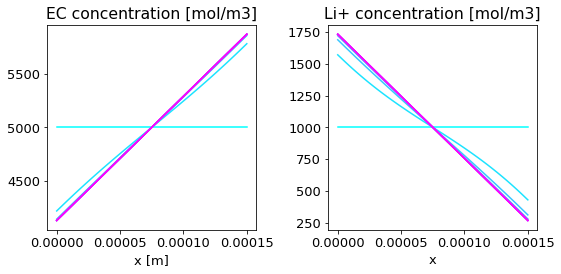

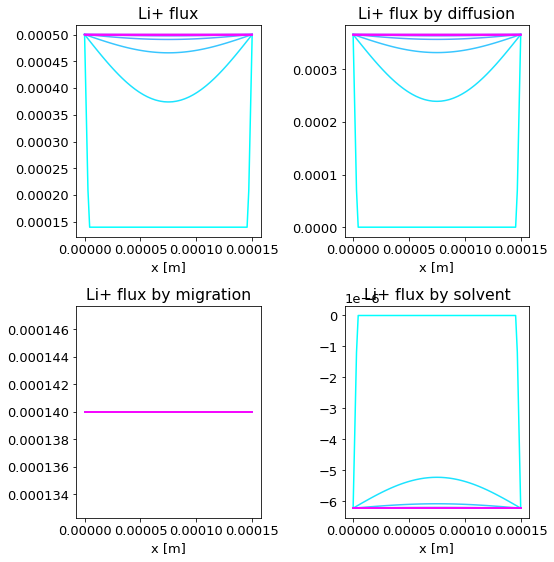

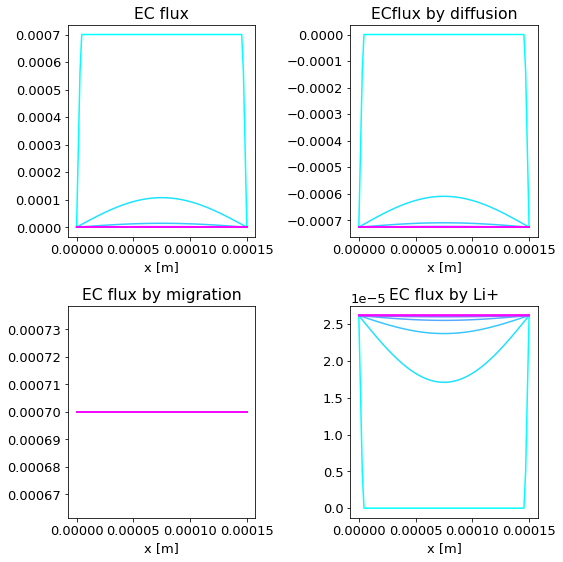

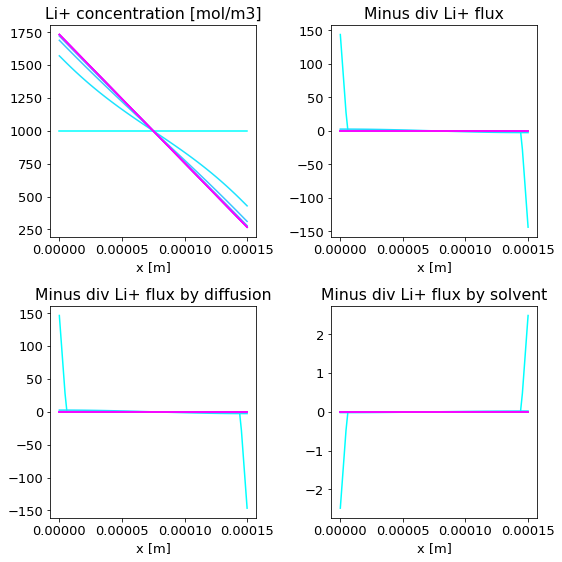

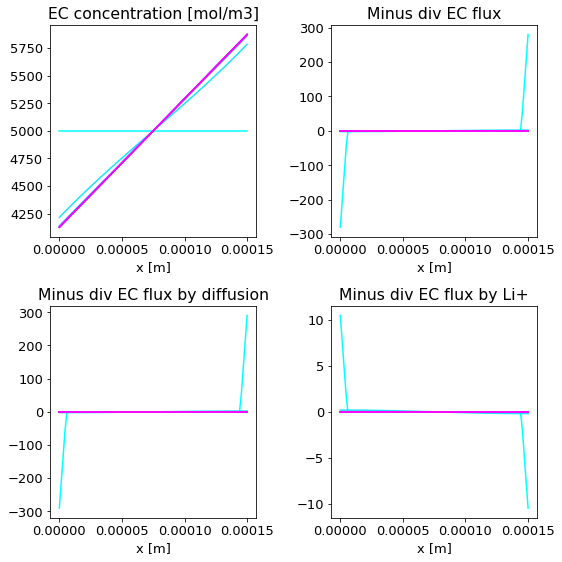

In [42]:
# mimic porous electrode:
D_e = 3e-10/8;  D_EC = 5e-10/8; D_cross = 3e-11/8;   t_0plus = 0.28; trans_i = -1.4;  t_max =720; i_app = 48; L_tot = 1.5e-4
sol_1,model_1= RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,trans_i,t_max ,i_app  ,L_tot )